This is the last in a series of posts which constitute a "lit review" of sorts, documenting the range of methods scholars are using to compute the distribution of topics over time. The strategies I am considering are:

+ [Average of topic weights per year (First Post)](http://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/)
+ [Smoothing or regression analysis (Second Post)](http://jeriwieringa.com/2017/06/23/calculating-and-visualizing-topic-significance-over-time-part-2/)
+ [Proportion of total weights per year (Third Post)](http://jeriwieringa.com/2017/06/23/calculating-and-visualizing-topic-significance-over-time-part-3/)
+ [Prevalence of the top topic per year (Final Post](http://jeriwieringa.com/2017/06/23/calculating-and-visualizing-topic-significance-over-time-part-4/)

To explore a range of strategies for computing and visualizing topics over time from a standard LDA model, I am using a model I created from my dissertation materials. You can download the files needed to follow along from [https://www.dropbox.com/s/9uf6kzkm1t12v6x/2017-06-21.zip?dl=0](https://www.dropbox.com/s/9uf6kzkm1t12v6x/2017-06-21.zip?dl=0).


In [1]:
# Load the necessary libraries
import gensim # Note: I am running 1.0.1
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd # Note: I am running 0.19.2
import pyLDAvis.gensim
import seaborn as sns
import warnings

In [2]:
# Enable in-notebook visualizations
%matplotlib inline

In [3]:
# Temporary fix for persistent warnings of an api change between pandas and seaborn.
warnings.filterwarnings('ignore')

In [4]:
pd.options.display.max_rows = 10

In [5]:
base_dir = "data"
period = "1859-to-1875"
directory = "historical_periods"

# Create the dataframes

I preprocessed the model to export various aspects of the model information into CSV files for ease of compiling. 

In [6]:
metadata_filename = os.path.join(base_dir,'2017-05-corpus-stats/2017-05-Composite-OCR-statistics.csv')
index_filename = os.path.join(base_dir, 'corpora', directory, '{}.txt'.format(period))
labels_filename = os.path.join(base_dir, 'dataframes', directory, '{}_topicLabels.csv'.format(period))
doc_topic_filename = os.path.join(base_dir, 'dataframes', directory, '{}_dtm.csv'.format(period))

In [7]:
def doc_list(index_filename):
    """
    Read in from a json document with index position and filename. 
    File was created during the creation of the corpus (.mm) file to document
    the filename for each file as it was processed.
    
    Returns the index information as a dataframe.
    """
    with open(index_filename) as data_file:    
        data = json.load(data_file)
    docs = pd.DataFrame.from_dict(data, orient='index').reset_index()
    docs.columns = ['index_pos', 'doc_id']
    docs['index_pos'] = docs['index_pos'].astype(int)
  
    return docs


def compile_dataframe( index, dtm, labels, metadata):
    """
    Combines a series of dataframes to create a large composit dataframe.
    """
    doc2metadata = index.merge(metadata, on='doc_id', how="left")
    topics_expanded = dtm.merge(labels, on='topic_id')
    
    df = topics_expanded.merge(doc2metadata, on="index_pos", how="left")
    
    return df

In [8]:
order = ['conference, committee, report, president, secretary, resolved',
         'quarterly, district, society, send, sept, business',
         'association, publishing, chart, dollar, xxii, sign',
         'mother, wife, told, went, young, school',
         'disease, physician, tobacco, patient, poison, medicine',
         'wicked, immortality, righteous, adam, flesh, hell',
        ]

In [9]:
def create_pointplot(df, y_value, hue=None, order=order, col=None, wrap=None, size=6, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='point', hue_order=order, hue=hue, 
                       col=col, col_wrap=wrap, col_order=order, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

In [10]:
metadata = pd.read_csv(metadata_filename, usecols=['doc_id', 'year','title'])
docs_index = doc_list(index_filename)
dt = pd.read_csv(doc_topic_filename)
labels = pd.read_csv(labels_filename)

The first step, following the pattern of [Andrew Goldstone for his topic model browser](https://github.com/agoldst/dfrtopics/blob/43362fd4aea25caedf59f610fb02f3aaa30334ca/R/matrices.R#L373-L415), is to normalize the weights for each document, so that they total to "1".

As a note, Goldstone first smooths the weights by adding the alpha hyperparameter to each of the weights, which I am not doing here.

In [11]:
# Reorient from long to wide
dtm = dt.pivot(index='index_pos', columns='topic_id', values='topic_weight').fillna(0)

# Divide each value in a row by the sum of the row to normalize the values
# https://stackoverflow.com/questions/18594469/normalizing-a-pandas-dataframe-by-row
dtm = dtm.div(dtm.sum(axis=1), axis=0)

# Shift back to a long dataframe
dt_norm = dtm.stack().reset_index()
dt_norm.columns = ['index_pos', 'topic_id', 'norm_topic_weight']

In [12]:
df = compile_dataframe(docs_index, dt_norm, labels, metadata)

In [13]:
df

,index_pos,topic_id,norm_topic_weight,topic_words,doc_id,year,title
0,0,0,0.045525,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page1.txt,1863,GCB
1,1,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page2.txt,1863,GCB
2,2,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page3.txt,1863,GCB
3,3,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page4.txt,1863,GCB
4,4,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page5.txt,1863,GCB
...,...,...,...,...,...,...,...
288595,11539,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page4.txt,1872,YI
288596,11540,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page5.txt,1872,YI
288597,11541,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page6.txt,1872,YI
288598,11542,24,0.012192,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page7.txt,1872,YI


# Data dictionary:

+ `index_pos` : Gensim uses the order in which the docs were streamed to link back the data and the source file. `index_pos` refers to the index id for the individual doc, which I used to link the resulting model information with the document name.
+ `topic_id` : The numerical id for each topic. For this model, I used 20 topics to classify the periodical pages.
+ `norm_topic_weight` : The proportion of the tokens in the document that are part of the topic, normalized per doc.
+ `topic_words` : The top 6 words in the topic.
+ `doc_id` : The file name of the document. The filename contains metadata information about the document, such as the periodical title, date of publication, volume, issue, and page number.
+ `year` : Year the document was published (according to the filename)
+ `title` : Periodical that the page was published in.

## Normalizing Weights to Proportion of Total

The final method for topic weights over time is calculating a normalized or proportional weight. If I read the code correctly, this is the approach that Goldstone uses in his [dfr topics library](https://github.com/agoldst/dfrtopics/blob/43362fd4aea25caedf59f610fb02f3aaa30334ca/R/matrices.R#L2-L122). Rather than computing the average weight, in this approach we sum up all of the values for each topic in a given time frame, and then normalize those values by dividing by the sum of all the weights in that period. In the normalized data, the sum of all the normalized weights for each time period is 1.

This allows us to see the proportion of the total weight that is held by each individual topic in each period. As a topic increases in a corpus, it takes up a larger proportion of the total weight.

In [14]:
y_df = df.groupby(['year', 'topic_id']).agg({'norm_topic_weight': 'sum'})

# This achieves a similar computation as the normalizing function above, but without converting into a matrix first.
# For each group (in this case year), we are dividing the values by the sum of the values. 
ny_df = y_df.groupby(level=0).apply(lambda x: x / x.sum()).reset_index()

ny_df.columns = ['year', 'topic_id', 'normalized_weight']
ny_df = ny_df.merge(labels, on="topic_id")

In [15]:
ny_df

,year,topic_id,normalized_weight,topic_words
0,1859,0,0.127749,"satan, salvation, sinner, righteousness, peace..."
1,1860,0,0.119807,"satan, salvation, sinner, righteousness, peace..."
2,1861,0,0.132227,"satan, salvation, sinner, righteousness, peace..."
3,1862,0,0.109252,"satan, salvation, sinner, righteousness, peace..."
4,1863,0,0.109100,"satan, salvation, sinner, righteousness, peace..."
...,...,...,...,...
420,1871,24,0.001333,"jerusalem, thess, parable, lazarus, thou_hast,..."
421,1872,24,0.001614,"jerusalem, thess, parable, lazarus, thou_hast,..."
422,1873,24,0.001359,"jerusalem, thess, parable, lazarus, thou_hast,..."
423,1874,24,0.002465,"jerusalem, thess, parable, lazarus, thou_hast,..."


In [16]:
# Limit the data to our 6 topic sample
ny_df_filtered = ny_df[(ny_df['topic_id'] >= 15) & (ny_df['topic_id'] <= 20)]

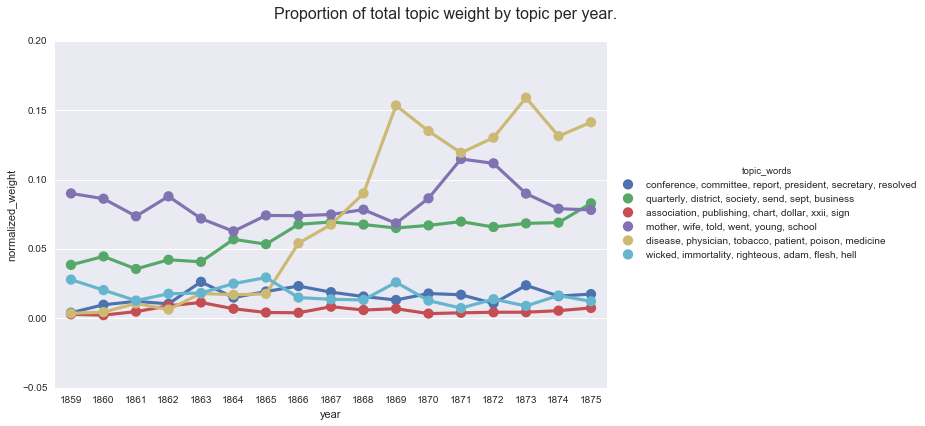

In [17]:
create_pointplot(ny_df_filtered, "normalized_weight", hue="topic_words", 
                 title="Proportion of total topic weight by topic per year.")

This graph is very similar to what we see when we use Seaborn to compute the mean topic weight per year.

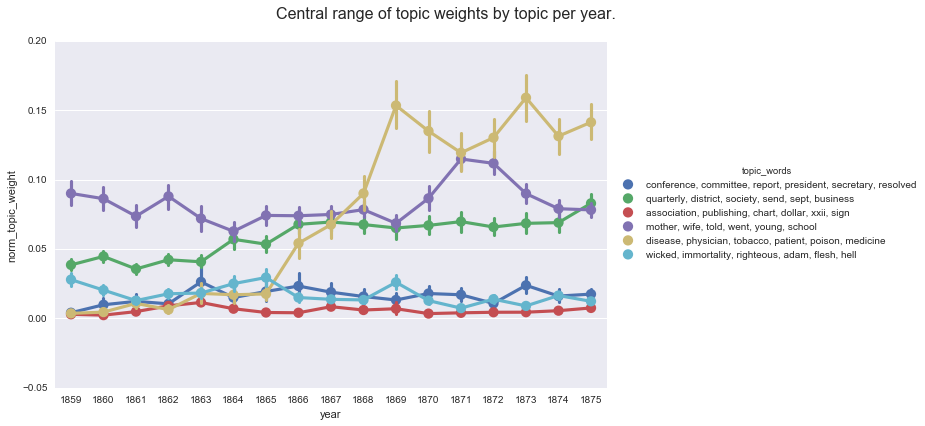

In [18]:
create_pointplot(df, 'norm_topic_weight', hue='topic_words',
                 title='Central range of topic weights by topic per year.'
                )

One advantage of this method is that it is easy to aggregate by a factor other than time, such as periodical title, to see the overall distribution of topics within different subsets of the corpus. 

In [19]:
titles = df.groupby(['title', 'topic_id']).agg({'norm_topic_weight': 'sum'})
titles = titles.groupby(level=0).apply(lambda x: x / x.sum()).reset_index()
titles = titles.merge(labels, on='topic_id')

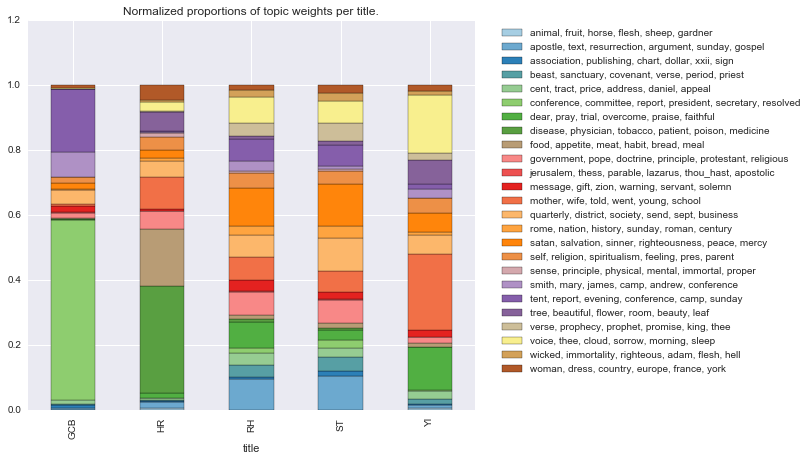

In [20]:
titles.pivot('title','topic_words', 'norm_topic_weight')\
.plot(kind='bar', stacked=True, colormap='Paired', 
      figsize=(8,7), title='Normalized proportions of topic weights per title.')\
.legend(bbox_to_anchor=(1.75, 1))

Another advantage of this method is that it makes it easier to accommodate the default Gensim data output (where values less than 1% are dropped). We can see this by charting the normalized weights after dropping the zero values and comparing that to a chart of the average weights after dropping the zero values.

In [21]:
# Remove the zero values we added in when normalizing each document
df2 = df[df['norm_topic_weight'] > 0]

In [22]:
p_df2 = df2.groupby(['year', 'topic_id']).agg({'norm_topic_weight': 'sum'})

# Normalize each group by dividing by the sum of the group
np_df2 = p_df2.groupby(level=0).apply(lambda x: x / x.sum()).reset_index()
np_df2.columns = ['year', 'topic_id', 'normalized_weight']
np_df2 = np_df2.merge(labels, on="topic_id")

In [23]:
np_df2_filtered = np_df2[(np_df2['topic_id'] >= 15) & (np_df2['topic_id'] <= 20)]

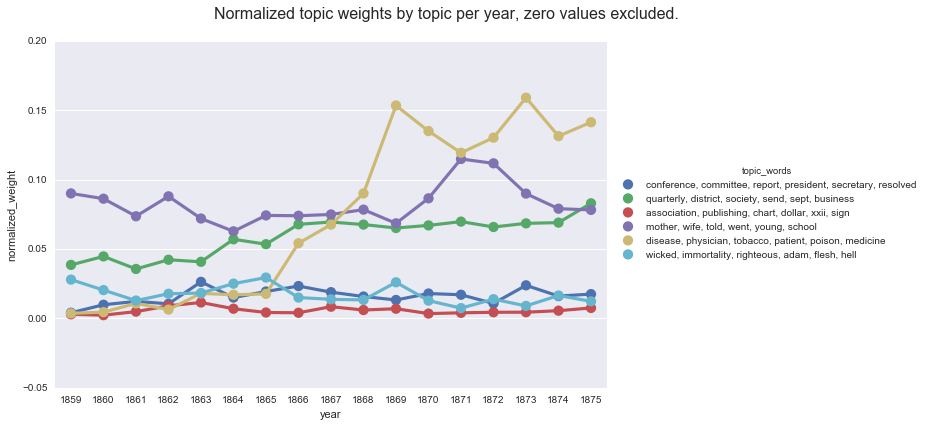

In [24]:
create_pointplot(np_df2_filtered, "normalized_weight", hue="topic_words", 
                 title="Normalized topic weights by topic per year, zero values excluded.")

Whereas, if we compute the mean values on the default Gensim report, we get a very different (and skewed) picture of the topic weights per year.

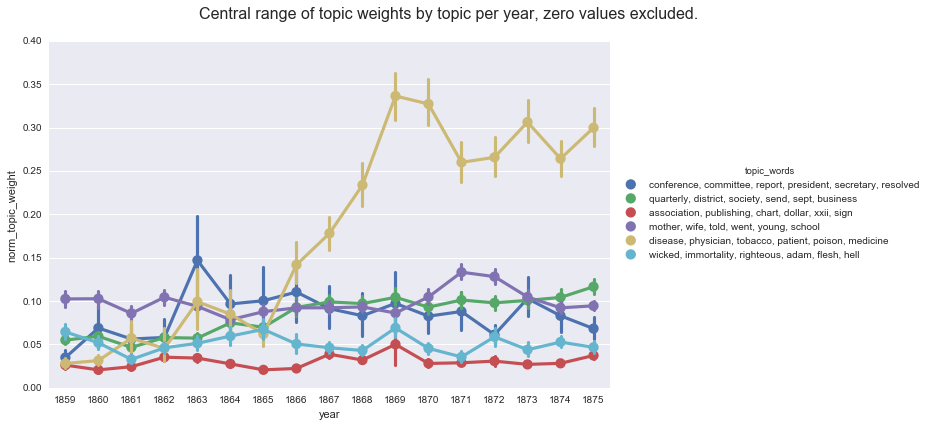

In [25]:
create_pointplot(df2, 'norm_topic_weight', hue='topic_words',
                 title='Central range of topic weights by topic per year, zero values excluded.'
                )

This series of posts came to be as I went searching for models of how to aggregate the topic weights per year and, due in no small part because I forgot to account for the different ways Gensim and Mallet handle low topic weights, produced very different graphs depending on the aggregation method. Each method I found is useful for highlighting different aspects of the data: computing the mean tell us about the average weight for each topic in a given group; computing smoothing lines and rolling averages points out broader trends for a particular topic; computing prevalence helps us see when a topic is prominent; and the normalized or proportional weights helps us see the topics in relationship to one another. 

If I have understood these methods correctly, then I find the proportional weight to be most useful for my particular questions and my data. I am interested in when and where different topics spike relative to other topics as a way to guide further research into the documents, a line of inquiry that the proportional weights are useful for exploring. Computing proportional or the normalized weights also helps me handle the default Gensim data more smoothly (by which I mean, with fewer opportunities for me to make mistakes).

A note on the visualizations: The charts in these notebooks are not my favorite in terms of design, readability, and accessibility. My apologies to anyone for whom the are illegible. I am still working out how best to create these visualizations for a range of users and am happy to provide an alternative if needed.

A special thanks to Amanda Regan for talking me through the code for her [visualizations of Eleanor Roosevelt's *My Day*](https://regan008.shinyapps.io/mining_my_day/).